In [1]:
%load_ext autoreload
%autoreload 2

# Dev script for calculating gradients in ECCO using xgcm

In [39]:
import numpy as np
import xarray as xr
from xgcm import Grid
import glob
import matplotlib.pyplot as plt

In [40]:
rootdir = '/data2/project/ECCO4v4/'

In [41]:
# shortwave
localdir = 'nctiles_monthly/MXLDEPTH/*/'
filename = 'MXLDEPTH_*.nc'
v = xr.open_mfdataset(rootdir+localdir+filename)
v = v.rename({'tile':'face'}).drop(['XC','YC','timestep','time_bnds'])

In [42]:
rootdir = '/home/gmacgilchrist/data/ECCO/'
filename = 'ECCO-GRID.nc'
grid = xr.open_dataset(rootdir+filename)
grid = grid.rename({'tile':'face'})
# def preprocess(ds):
#     dsnew = ds.copy()
#     dsnew = dsnew.expand_dims({'face':[int(ds.encoding["source"][41:45])]})
#     return dsnew
# localdir = 'nctiles_grid/'
# filename = 'GRID.*.nc'
# grid = xr.open_mfdataset(rootdir+localdir+filename, preprocess=preprocess)
# grid = grid.rename({'i1':'k','i2':'j','i3':'i'})
# grid

In [43]:
ds = xr.merge([v,grid])
ds

,Array,Chunk
Bytes,131.41 MB,421.20 kB
Shape,"(312, 13, 90, 90)","(1, 13, 90, 90)"
Count,936 Tasks,312 Chunks
Type,float32,numpy.ndarray


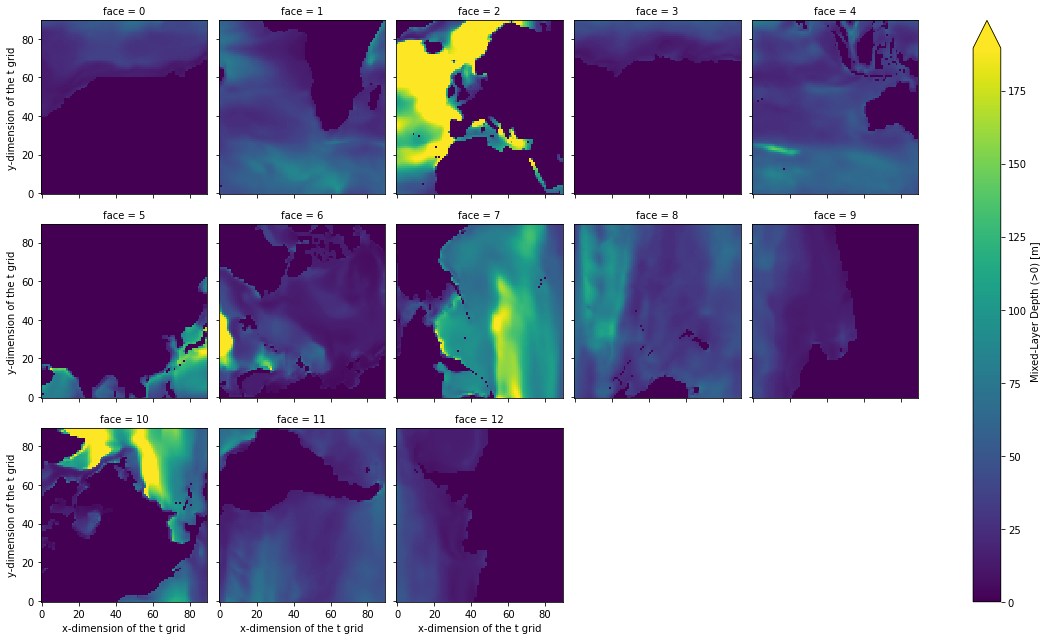

In [44]:
ds['MXLDEPTH'].isel(time=0).plot(col='face', col_wrap=5, robust = True)

In [45]:
# define the connectivity between faces
# face_connections = {'face':
#                     {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
#                          'Y':  (None,             (1, 'Y', False))},
#                      1: {'X':  ((11, 'Y', False), (4, 'X', False)),
#                          'Y':  ((0, 'Y', False),  (2, 'Y', False))},
#                      2: {'X':  ((10, 'Y', False), (5, 'X', False)),
#                          'Y':  ((1, 'Y', False),  (6, 'X', False))},
#                      3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
#                          'Y':  (None,             (4, 'Y', False))},
#                      4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
#                          'Y':  ((3, 'Y', False),  (5, 'Y', False))},
#                      5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
#                          'Y':  ((4, 'Y', False),  (6, 'Y', False))},
#                      6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
#                          'Y':  ((5, 'Y', False),  (10, 'X', False))},
#                      7: {'X':  ((6, 'X', False),  (8, 'X', False)),
#                          'Y':  ((5, 'X', False),  (10, 'Y', False))},
#                      8: {'X':  ((7, 'X', False),  (9, 'X', False)),
#                          'Y':  ((4, 'X', False),  (11, 'Y', False))},
#                      9: {'X':  ((8, 'X', False),  None),
#                          'Y':  ((3, 'X', False),  (12, 'Y', False))},
#                      10: {'X': ((6, 'Y', False),  (11, 'X', False)),
#                           'Y': ((7, 'Y', False),  (2, 'X', False))},
#                      11: {'X': ((10, 'X', False), (12, 'X', False)),
#                           'Y': ((8, 'Y', False),  (1, 'X', False))},
#                      12: {'X': ((11, 'X', False), None),
#                           'Y': ((9, 'Y', False),  (0, 'X', False))}}}

face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                     'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                     'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                     'Y':  ((1, 'Y', False),  (6, 'X', False))},
                 3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                     'Y':  (None,             (4, 'Y', False))},
                 4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                     'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                 5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                     'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                 6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                     'Y':  ((5, 'Y', False),  (10, 'X', False))},
                 7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                     'Y':  ((5, 'X', False),  (10, 'Y', False))},
                 8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                     'Y':  ((4, 'X', False),  (11, 'Y', False))},
                 9: {'X':  ((8, 'X', False),  None),
                     'Y':  ((3, 'X', False),  (12, 'Y', False))},
                 10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                      'Y': ((7, 'Y', False),  (2, 'X', False))},
                 11: {'X': ((10, 'X', False), (12, 'X', False)),
                      'Y': ((8, 'Y', False),  (1, 'X', False))},
                 12: {'X': ((11, 'X', False), None),
                      'Y': ((9, 'Y', False),  (0, 'X', False))}}}

# ds['DRW'] = ds.hFacW * ds.DRF #vertical cell size at u point
# ds['DRS'] = ds.hFacS * ds.DRF #vertical cell size at v point
# ds['DRC'] = ds.hFacC * ds.DRF #vertical cell size at tracer point

# metrics = {
#     ('X',): ['DXC', 'DXG'], # X distances
#     ('Y',): ['DYC', 'DYG'], # Y distances
#     ('Z',): ['DRW', 'DRS', 'DRC'], # Z distances
#     ('X', 'Y'): ['RAC', 'RAZ', 'RC', 'RF'] # Areas
# }

# create the grid object
# xgrid = Grid(ds, periodic=False, face_connections=face_connections, metrics=metrics)
xgrid = Grid(ds, face_connections=face_connections)
xgrid

<xgcm.Grid>
Z Axis (periodic, boundary=None):
  * center   k --> left
  * left     k_l --> center
  * outer    k_p1 --> center
  * right    k_u --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
T Axis (periodic, boundary=None):
  * center   time
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

In [48]:
# Calculate gradients in field
dg = xgrid.diff(ds['MXLDEPTH'], 'X')
gxg = xgrid.interp(dg ,'X')
# dgdx = xgrid.diff(gxg, 'X')

ValueError: 'j_g' not found in array dimensions ('time', 'face', 'j', 'i_g')

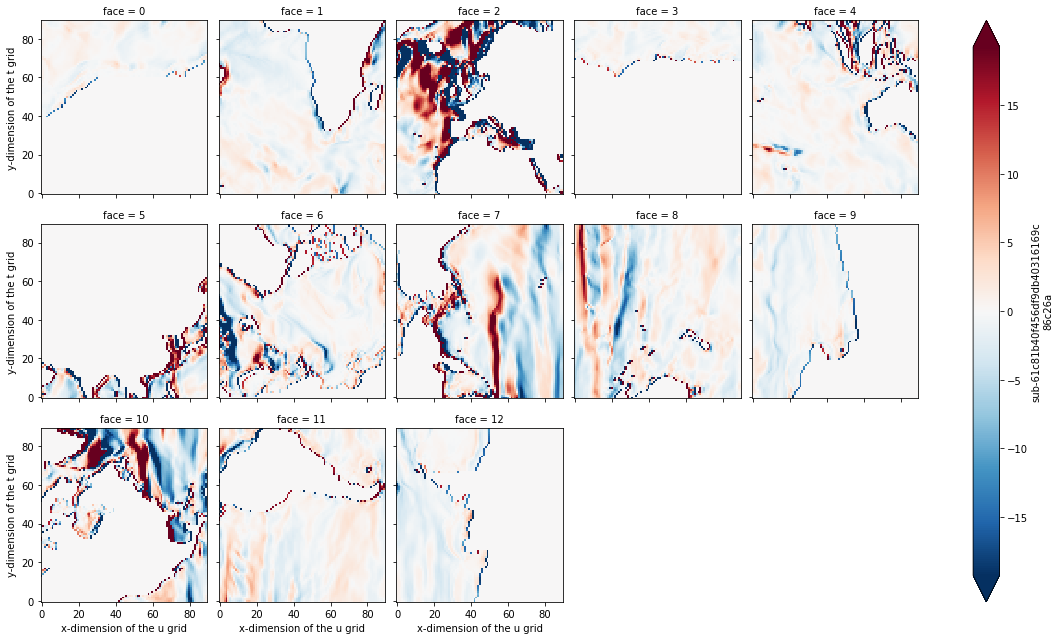

In [47]:
dg.isel(time=0).plot(col='face', col_wrap=5, robust = True)

In [47]:
gxg = xgrid.interp(dg ,'Y', boundary = 'fill')

ValueError: 'i' not found in array dimensions ('time', 'face', 'j', 'i_g')